In [1]:
import torch
import torchvision
from torch import nn


def conv3x3(i: int, o: int) -> nn.Conv2d:
    """3×3 convolution with padding=1 (same spatial size)."""
    return nn.Conv2d(i, o, kernel_size=3, padding=1, bias=False)


class ConvGelu(nn.Module):
    """Conv → GELU helper block (replacing Conv+ReLU)."""

    def __init__(self, i: int, o: int):
        super().__init__()
        self.block = nn.Sequential(
            conv3x3(i, o),
            nn.GELU(),
        )

    def forward(self, x):
        return self.block(x)


class DecoderBlock(nn.Module):
    """Decoder up‑sampling block: (Conv→GELU) ×1  +  2× upsample via transpose‑conv."""

    def __init__(self, i: int, m: int, o: int):
        super().__init__()
        self.block = nn.Sequential(
            ConvGelu(i, m),
            nn.ConvTranspose2d(m, o, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.GELU(),
        )

    def forward(self, x):
        return self.block(x)


class InvertedBottleneck(nn.Module):
    """MobileNet‑v2 style inverted residual bottleneck.

    Args:
        ch (int): input/output channels.
        exp (int): expansion factor. Default 4 (i.e. ch → ch*exp → ch).
    """

    def __init__(self, ch: int, exp: int = 4):
        super().__init__()
        mid = ch * exp
        self.block = nn.Sequential(
            # 1×1 point‑wise expansion
            nn.Conv2d(ch, mid, kernel_size=1, bias=False),
            nn.BatchNorm2d(mid),
            nn.GELU(),
            # 3×3 depth‑wise conv
            nn.Conv2d(mid, mid, kernel_size=3, padding=1, groups=mid, bias=False),
            nn.BatchNorm2d(mid),
            nn.GELU(),
            # 1×1 point‑wise projection back
            nn.Conv2d(mid, ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(ch),
        )

    def forward(self, x):
        return x + self.block(x)  # residual connection


class UNet11_4ch(nn.Module):
    """UNet‑11 backbone with 4‑channel input, GELU activations, and an extra inverted bottleneck before the final head."""

    def __init__(self, num_filters: int = 32, pretrained: bool = True):
        super().__init__()

        # ─────── Encoder (VGG11) ────────────────────────────────────────────
        enc = torchvision.models.vgg11(pretrained=pretrained).features

        # First conv: 4→64 (copy RGB weights and set 4th channel to mean)
        old_conv1 = enc[0]  # 3→64
        new_conv1 = nn.Conv2d(4, 64, kernel_size=3, padding=1, bias=False)
        if pretrained:
            with torch.no_grad():
                new_conv1.weight[:, :3] = old_conv1.weight  # copy RGB
                new_conv1.weight[:, 3:4] = old_conv1.weight.mean(dim=1, keepdim=True)
        enc[0] = new_conv1
        self.encoder = enc  # keep as torch.nn.Sequential

        # Shortcut handles
        self.gelu = nn.GELU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1, self.conv2 = enc[0], enc[3]
        self.conv3s, self.conv3 = enc[6], enc[8]
        self.conv4s, self.conv4 = enc[11], enc[13]
        self.conv5s, self.conv5 = enc[16], enc[18]

        # ─────── Decoder ──────────────────────────────────────────────────
        nf = num_filters
        self.center = DecoderBlock(nf * 8 * 2, nf * 8 * 2, nf * 8)
        self.dec5 = DecoderBlock(nf * (16 + 8), nf * 8 * 2, nf * 8)
        self.dec4 = DecoderBlock(nf * (16 + 8), nf * 8 * 2, nf * 4)
        self.dec3 = DecoderBlock(nf * (8 + 4), nf * 4 * 2, nf * 2)
        self.dec2 = DecoderBlock(nf * (4 + 2), nf * 2 * 2, nf)
        self.dec1 = ConvGelu(nf * (2 + 1), nf)

        # ─────── Inverted Bottleneck  +  Final head ────────────────────────
        self.inv = InvertedBottleneck(nf, exp=4)
        self.final = nn.Conv2d(nf, 1, kernel_size=1)

    # ---------------------------------------------------------------------
    def _enc_forward(self, x):
        c1 = self.gelu(self.conv1(x))
        c2 = self.gelu(self.conv2(self.pool(c1)))
        c3s = self.gelu(self.conv3s(self.pool(c2)))
        c3 = self.gelu(self.conv3(c3s))
        c4s = self.gelu(self.conv4s(self.pool(c3)))
        c4 = self.gelu(self.conv4(c4s))
        c5s = self.gelu(self.conv5s(self.pool(c4)))
        c5 = self.gelu(self.conv5(c5s))
        return c1, c2, c3, c4, c5

    def forward(self, x):
        c1, c2, c3, c4, c5 = self._enc_forward(x)
        ctr = self.center(self.pool(c5))

        d5 = self.dec5(torch.cat([ctr, c5], dim=1))
        d4 = self.dec4(torch.cat([d5, c4], dim=1))
        d3 = self.dec3(torch.cat([d4, c3], dim=1))
        d2 = self.dec2(torch.cat([d3, c2], dim=1))
        d1 = self.dec1(torch.cat([d2, c1], dim=1))

        out = self.inv(d1)  # apply inverted bottleneck residual block
        return self.final(out)




In [3]:
# train_unet4ch.py
import os, csv, random, argparse
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import torch, torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
#from model import UNet11_4ch                 # ★★ 改成 4ch 版本

# ---------------- Dataset ----------------
class AerialPatchDataset4C(Dataset):
    """
    root/
     ├─ images/        austin1.tif ...
     ├─ depth_images/  austin1_depth.png / tif / jpg ...
     └─ gt/            austin1.tif (遮罩，與 images 同名)
    """
    COMMON_EXTS = [".png", ".jpg", ".jpeg", ".tif", ".tiff"]

    def __init__(self, root, crop=256):
        self.crop      = crop
        self.img_dir   = os.path.join(root, "images")
        self.depth_dir = os.path.join(root, "depth_images")
        self.mask_dir  = os.path.join(root, "gt")

        self.names     = sorted(os.listdir(self.img_dir))           # ex: austin1.tif
        self.depth_map = self._build_depth_map()                    # ★★ 建對應表

        self.mean = torch.tensor([0.485,0.456,0.406,0.5]).view(4,1,1)
        self.std  = torch.tensor([0.229,0.224,0.225,0.5]).view(4,1,1)

    # ----------  新增：掃描 depth_images ----------
    def _build_depth_map(self):
        depth_files = os.listdir(self.depth_dir)
        depth_dict  = {}
        for f in depth_files:
            stem, ext = os.path.splitext(f)
            if stem.endswith("_depth"):
                base = stem[:-6]                    # 去掉 "_depth"
                depth_dict[base] = f
        return depth_dict                           # {austin1: austin1_depth.png}

    def __len__(self): return len(self.names)

    def _random_crop(self, img, depth, msk):
        h, w = img.shape[:2]; ch = cw = self.crop
        top  = random.randint(0, h - ch); left = random.randint(0, w - cw)
        return (arr[top:top+ch, left:left+cw] for arr in (img, depth, msk))

    def __getitem__(self, idx):
        name = self.names[idx]                      # austin1.tif
        stem, ext = os.path.splitext(name)          # austin1, .tif
        try:
            # --- 找對應的深度圖檔名 ---
            if stem in self.depth_map:
                depth_fname = self.depth_map[stem]
            else:
                # 保險：按副檔名猜測
                depth_fname = None
                for ex in [ext] + self.COMMON_EXTS:
                    cand = f"{stem}_depth{ex}"
                    if os.path.exists(os.path.join(self.depth_dir, cand)):
                        depth_fname = cand; break
                if depth_fname is None:
                    raise FileNotFoundError(f"找不到 {stem}_depth.*")

            # --- 讀檔 ---
            rgb   = Image.open(os.path.join(self.img_dir,   name)).convert("RGB")
            depth = Image.open(os.path.join(self.depth_dir, depth_fname)).convert("L")
            msk   = Image.open(os.path.join(self.mask_dir,  name)).convert("L")

            rgb   = np.asarray(rgb)
            depth = np.asarray(depth)[..., None]              # H×W×1
            msk   = (np.asarray(msk) // 255).astype(np.uint8)

            rgb, depth, msk = self._random_crop(rgb, depth, msk)

            # --- to tensor ---
            rgb   = torch.from_numpy(rgb).permute(2,0,1).float() / 255.0
            depth = torch.from_numpy(depth).permute(2,0,1).float() / 255.0
            img4  = torch.cat([rgb, depth], 0)                # 4×H×W
            img4  = (img4 - self.mean) / self.std
            msk   = torch.from_numpy(msk).float().unsqueeze(0)
            return img4, msk

        except Exception as e:
            print(f"❌ [錯誤] {name}: {e}")
            return (torch.zeros(4, self.crop, self.crop),
                    torch.zeros(1, self.crop, self.crop))

# ---------------- Metric -----------------
def dice_coef(pred, target, eps=1e-7):
    pred = (torch.sigmoid(pred) > 0.5).float()
    inter = (pred * target).sum((1,2,3))
    union = pred.sum((1,2,3)) + target.sum((1,2,3))
    return ((2*inter+eps)/(union+eps)).mean()

# ---------------- Train ------------------
def main(args):
    torch.multiprocessing.set_start_method('spawn', force=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("🚀 Device:", device)

    root = r"E:\論文\空拍地圖語意分割\Depth4UNet\AerialImageDataset\train"
    if not os.path.exists(root):
        print(f"❌ 找不到資料目錄 {root}"); return

    data = AerialPatchDataset4C(root, crop=args.crop)
    print(f"📊 共 {len(data)} 張影像")
    v = int(0.1*len(data))
    train_ds, val_ds = torch.utils.data.random_split(data, [len(data)-v, v])

    def loader(ds, shf): return DataLoader(
        ds, batch_size=args.bs, shuffle=shf,
        num_workers=0, pin_memory=False, persistent_workers=False)

    train_ld, val_ld = loader(train_ds, True), loader(val_ds, False)

    model = UNet11_4ch(pretrained=True).to(device)      # ★★
    crit  = nn.BCEWithLogitsLoss()
    opt   = torch.optim.Adam(model.parameters(), lr=args.lr)
    scaler= torch.amp.GradScaler(device.type)

    best = 0; os.makedirs("checkpoints", exist_ok=True)
    with open("metrics.csv","w",newline="") as f:
        csv.writer(f).writerow(["epoch","train_loss","val_loss","dice"])

    for ep in range(1, args.epochs+1):
        # ---- train ----
        model.train(); tr_loss=0; n_tr=0
        for img,msk in tqdm(train_ld, desc=f"Ep{ep}/{args.epochs} train"):
            img,msk = img.to(device), msk.to(device)
            with torch.amp.autocast(device.type):
                pred = model(img); loss = crit(pred, msk)
            opt.zero_grad(); scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            tr_loss += loss.item(); n_tr += 1

        # ---- val ----
        model.eval(); vl_loss=0; dices=[]; n_v=0
        with torch.no_grad():
            for img,msk in tqdm(val_ld, desc=f"Ep{ep}/{args.epochs} val"):
                img,msk = img.to(device), msk.to(device)
                with torch.amp.autocast(device.type):
                    pred = model(img); loss = crit(pred, msk)
                vl_loss += loss.item(); dices.append(dice_coef(pred, msk).item()); n_v += 1

        tr_loss /= max(n_tr,1); vl_loss /= max(n_v,1); dice = np.mean(dices) if dices else 0
        print(f"📝 Ep{ep} train={tr_loss:.4f} val={vl_loss:.4f} dice={dice:.4f}")
        with open("metrics.csv","a",newline="") as f:
            csv.writer(f).writerow([ep,tr_loss,vl_loss,dice])

        if dice > best:
            best = dice
            torch.save(model.state_dict(), "checkpoints/best_unet4ch(GELU).pth")
            print(f"  👑  Saved best model (dice {best:.4f})")

# ---------------- Run --------------------
if __name__ == "__main__":
    args = argparse.Namespace(epochs=100, bs=4, lr=1e-4, crop=256)
    main(args)


🚀 Device: cuda
📊 共 180 張影像


Ep1/100 val: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


📝 Ep1 train=0.5191 val=0.4646 dice=0.1685
  👑  Saved best model (dice 0.1685)


Ep2/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


📝 Ep2 train=0.4104 val=0.4000 dice=0.4208
  👑  Saved best model (dice 0.4208)


Ep3/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


📝 Ep3 train=0.3287 val=0.3521 dice=0.5528
  👑  Saved best model (dice 0.5528)


Ep4/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


📝 Ep4 train=0.2709 val=0.2875 dice=0.4873


Ep5/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


📝 Ep5 train=0.3109 val=0.3759 dice=0.4302


Ep6/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


📝 Ep6 train=0.2490 val=0.3466 dice=0.7018
  👑  Saved best model (dice 0.7018)


Ep7/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


📝 Ep7 train=0.2147 val=0.2491 dice=0.6633


Ep8/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


📝 Ep8 train=0.2149 val=0.2581 dice=0.5134


Ep9/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


📝 Ep9 train=0.2056 val=0.2404 dice=0.7911
  👑  Saved best model (dice 0.7911)


Ep10/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


📝 Ep10 train=0.2398 val=0.2296 dice=0.6283


Ep11/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


📝 Ep11 train=0.2315 val=0.2601 dice=0.7281


Ep12/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


📝 Ep12 train=0.2094 val=0.2141 dice=0.6432


Ep13/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


📝 Ep13 train=0.2469 val=0.2075 dice=0.7787


Ep14/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


📝 Ep14 train=0.2345 val=0.1903 dice=0.4068


Ep15/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


📝 Ep15 train=0.2058 val=0.2915 dice=0.7340


Ep16/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


📝 Ep16 train=0.1922 val=0.3677 dice=0.7198


Ep17/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


📝 Ep17 train=0.1955 val=0.3403 dice=0.6968


Ep18/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


📝 Ep18 train=0.2192 val=0.2553 dice=0.7397


Ep19/100 val: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


📝 Ep19 train=0.1684 val=0.1792 dice=0.7094


Ep20/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


📝 Ep20 train=0.1968 val=0.1916 dice=0.6603


Ep21/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


📝 Ep21 train=0.1887 val=0.1629 dice=0.7794


Ep22/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


📝 Ep22 train=0.1995 val=0.1781 dice=0.7114


Ep23/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


📝 Ep23 train=0.1910 val=0.1977 dice=0.8142
  👑  Saved best model (dice 0.8142)


Ep24/100 val: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


📝 Ep24 train=0.2001 val=0.2104 dice=0.5795


Ep25/100 val: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


📝 Ep25 train=0.1752 val=0.1899 dice=0.8112


Ep26/100 val: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


📝 Ep26 train=0.1811 val=0.2114 dice=0.8387
  👑  Saved best model (dice 0.8387)


Ep27/100 val: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


📝 Ep27 train=0.1623 val=0.2216 dice=0.6855


Ep28/100 val: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


📝 Ep28 train=0.2025 val=0.1857 dice=0.8166


Ep29/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


📝 Ep29 train=0.1900 val=0.2617 dice=0.8246


Ep30/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


📝 Ep30 train=0.1498 val=0.1610 dice=0.6310


Ep31/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


📝 Ep31 train=0.1583 val=0.1439 dice=0.7694


Ep32/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep32 train=0.1667 val=0.1956 dice=0.7818


Ep33/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


📝 Ep33 train=0.1468 val=0.2499 dice=0.7867


Ep34/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep34 train=0.1865 val=0.1964 dice=0.8008


Ep35/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep35 train=0.1694 val=0.1335 dice=0.5921


Ep36/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep36 train=0.1729 val=0.1724 dice=0.7727


Ep37/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep37 train=0.1894 val=0.1488 dice=0.6386


Ep38/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


📝 Ep38 train=0.1699 val=0.1698 dice=0.7308


Ep39/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep39 train=0.1683 val=0.1319 dice=0.7736


Ep40/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep40 train=0.1547 val=0.1575 dice=0.8171


Ep41/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep41 train=0.1908 val=0.1887 dice=0.6716


Ep42/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


📝 Ep42 train=0.1358 val=0.2160 dice=0.8342


Ep43/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


📝 Ep43 train=0.1948 val=0.2820 dice=0.7276


Ep44/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep44 train=0.1702 val=0.1597 dice=0.7036


Ep45/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep45 train=0.1510 val=0.1755 dice=0.6433


Ep46/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep46 train=0.1835 val=0.1860 dice=0.8144


Ep47/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep47 train=0.1729 val=0.1931 dice=0.7488


Ep48/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep48 train=0.1600 val=0.1863 dice=0.6550


Ep49/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep49 train=0.1321 val=0.2032 dice=0.7493


Ep50/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


📝 Ep50 train=0.1558 val=0.3126 dice=0.8079


Ep51/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


📝 Ep51 train=0.1420 val=0.1888 dice=0.7442


Ep52/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep52 train=0.1743 val=0.1586 dice=0.7468


Ep53/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep53 train=0.1402 val=0.2071 dice=0.7021


Ep54/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


📝 Ep54 train=0.1409 val=0.2335 dice=0.7569


Ep55/100 val: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


📝 Ep55 train=0.1579 val=0.2304 dice=0.8327


Ep56/100 val: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


📝 Ep56 train=0.1596 val=0.1795 dice=0.8113


Ep57/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


📝 Ep57 train=0.1681 val=0.2051 dice=0.6640


Ep58/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


📝 Ep58 train=0.1615 val=0.2032 dice=0.7818


Ep59/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep59 train=0.1760 val=0.1950 dice=0.8232


Ep60/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep60 train=0.1623 val=0.1996 dice=0.7392


Ep61/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep61 train=0.1327 val=0.1702 dice=0.6673


Ep62/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep62 train=0.1364 val=0.3760 dice=0.6394


Ep63/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep63 train=0.1480 val=0.1399 dice=0.8366


Ep64/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep64 train=0.1456 val=0.2660 dice=0.8282


Ep65/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


📝 Ep65 train=0.1368 val=0.1643 dice=0.8202


Ep66/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep66 train=0.1537 val=0.2118 dice=0.7247


Ep67/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep67 train=0.1597 val=0.1568 dice=0.7457


Ep68/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep68 train=0.1344 val=0.1451 dice=0.7237


Ep69/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep69 train=0.1378 val=0.1947 dice=0.6614


Ep70/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


📝 Ep70 train=0.1685 val=0.1190 dice=0.7519


Ep71/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep71 train=0.1618 val=0.1614 dice=0.7074


Ep72/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep72 train=0.1497 val=0.2517 dice=0.8074


Ep73/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep73 train=0.1668 val=0.2101 dice=0.6014


Ep74/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep74 train=0.1503 val=0.1371 dice=0.8035


Ep75/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep75 train=0.1522 val=0.2018 dice=0.7687


Ep76/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep76 train=0.1316 val=0.1538 dice=0.7706


Ep77/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep77 train=0.1498 val=0.1879 dice=0.7799


Ep78/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep78 train=0.1328 val=0.1765 dice=0.7754


Ep79/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


📝 Ep79 train=0.1734 val=0.1673 dice=0.7163


Ep80/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep80 train=0.1588 val=0.2050 dice=0.7795


Ep81/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep81 train=0.1632 val=0.1365 dice=0.8243


Ep82/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


📝 Ep82 train=0.1553 val=0.1393 dice=0.7344


Ep83/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep83 train=0.1630 val=0.1736 dice=0.7827


Ep84/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


📝 Ep84 train=0.1437 val=0.1962 dice=0.7291


Ep85/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep85 train=0.1318 val=0.1304 dice=0.7324


Ep86/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep86 train=0.1627 val=0.1980 dice=0.7751


Ep87/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep87 train=0.1390 val=0.1068 dice=0.6319


Ep88/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep88 train=0.1453 val=0.1663 dice=0.7375


Ep89/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep89 train=0.1330 val=0.1248 dice=0.8115


Ep90/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep90 train=0.1432 val=0.2177 dice=0.7607


Ep91/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep91 train=0.1303 val=0.1907 dice=0.7998


Ep92/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep92 train=0.1421 val=0.1597 dice=0.7624


Ep93/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep93 train=0.1946 val=0.1634 dice=0.8115


Ep94/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep94 train=0.1496 val=0.1423 dice=0.6811


Ep95/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep95 train=0.1363 val=0.1685 dice=0.8252


Ep96/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep96 train=0.1372 val=0.1069 dice=0.8269


Ep97/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep97 train=0.1290 val=0.2102 dice=0.7577


Ep98/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep98 train=0.1363 val=0.1349 dice=0.7609


Ep99/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep99 train=0.1344 val=0.1434 dice=0.8027


Ep100/100 val: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]

📝 Ep100 train=0.1526 val=0.1442 dice=0.8746
  👑  Saved best model (dice 0.8746)


In [ ]:
# %% [markdown]
# # Evaluate **UNet11_4ch** & Plot Precision-Recall Curve
#
# 1. 先設定 `CKPT_PATH` 與 `DATA_ROOT`  
# 2. Run all cells / 執行整支 script  
# 3. 會列出 matched layers、計算 PR 曲線與 AP，並存出
#    * `pr_curve.png`
#    * `val_pred.npz`

# %% [markdown]
# ## （可選）安裝相依套件
# 如果缺 `scikit-learn` / `matplotlib`，取消註解以下一行安裝
# !pip install scikit-learn matplotlib tqdm

# %% Imports & helpers
import os, torch, numpy as np, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import precision_recall_curve, average_precision_score

# ---- 匯入你的模型與 Dataset ----
from model import UNet11_4ch
from train_unet4ch import AerialPatchDataset4C

def load_ckpt(model, ckpt_path, label="UNet4ch"):
    """安全載入權重並回報相符層數"""
    ckpt = torch.load(ckpt_path, map_location="cpu")
    model_state = model.state_dict()
    compatible = {k: v for k, v in ckpt.items()
                  if k in model_state and v.shape == model_state[k].shape}
    model_state.update(compatible)
    model.load_state_dict(model_state)
    print(f"{label}: matched {len(compatible)} / {len(model_state)} layers")
    return model

# %% 🔧 路徑與參數（請修改這裡）
CKPT_PATH  = r"checkpoints/best_unet4ch(GELU).pth"  # ← 你的 checkpoint
DATA_ROOT  = r"E:\論文\空拍地圖語意分割\Depth4UNet\AerialImageDataset\train"  # ← 資料集根目錄
BATCH_SIZE = 4
CROP_SIZE  = 256
VAL_RATIO  = 0.10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Device:", device)

# %% Dataset & DataLoader
ds = AerialPatchDataset4C(DATA_ROOT, crop=CROP_SIZE)
val_len = int(len(ds) * VAL_RATIO)
_, val_ds = torch.utils.data.random_split(ds, [len(ds) - val_len, val_len])

val_ld = torch.utils.data.DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, pin_memory=False)

# %% Model
model = UNet11_4ch(pretrained=False).to(device)
model = load_ckpt(model, CKPT_PATH)

# %% Inference: collect y_true / y_score
model.eval()
y_true, y_score = [], []
with torch.no_grad():
    for img, msk in tqdm(val_ld, desc="Infer val"):
        img = img.to(device)
        prob = model(img).sigmoid().cpu()   # (B,1,H,W) 機率
        y_score.append(prob.flatten())
        y_true.append(msk.flatten())

y_true  = torch.cat(y_true).numpy()
y_score = torch.cat(y_score).numpy()
print(f"Collected {y_true.shape[0]:,} pixels for evaluation")

# %% PR curve & Average Precision
precision, recall, _ = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)
print(f"Average Precision = {ap:.4f}")

# %% Plot & save
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"PR Curve (AP = {ap:.4f})")
plt.grid()
plt.tight_layout()
plt.savefig("pr_curve.png")
print("📈  Saved pr_curve.png")

# Save raw arrays
np.savez_compressed("val_pred.npz", y_true=y_true, y_score=y_score)
print("💾  Saved val_pred.npz")


usage: ipykernel_launcher.py [-h] --ckpt CKPT --data-root DATA_ROOT [--bs BS]
                             [--crop CROP] [--val-ratio VAL_RATIO]
ipykernel_launcher.py: error: the following arguments are required: --ckpt, --data-root


SystemExit: 2

c:\Users\op237\miniconda3\envs\Depth4UNet\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


✅ dice_by_epoch.csv  已寫出
✅ pr_curve.csv       已寫出
✅ loss_curve.png     已寫出
✅ conf_matrix.png    已寫出


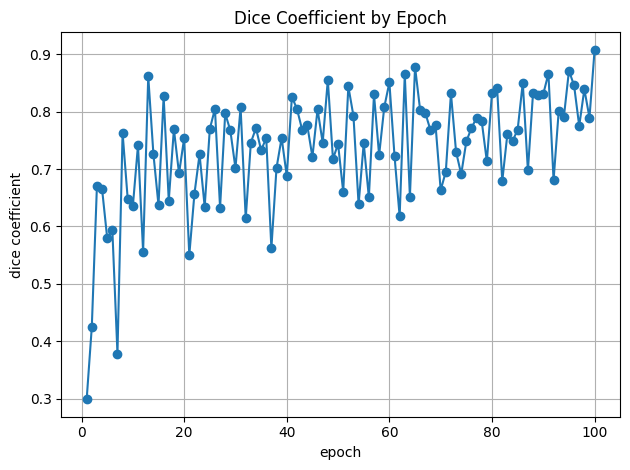

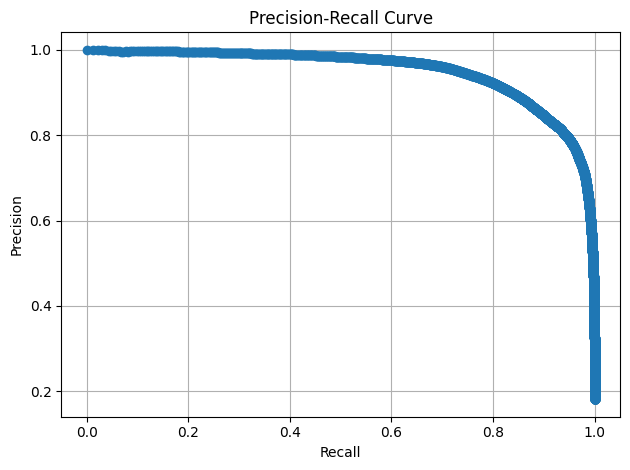

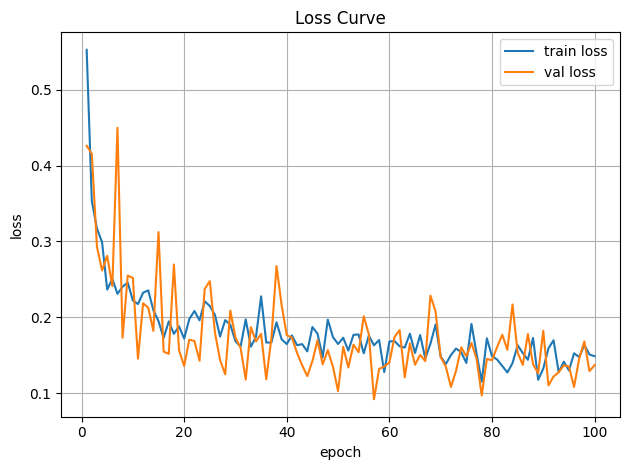

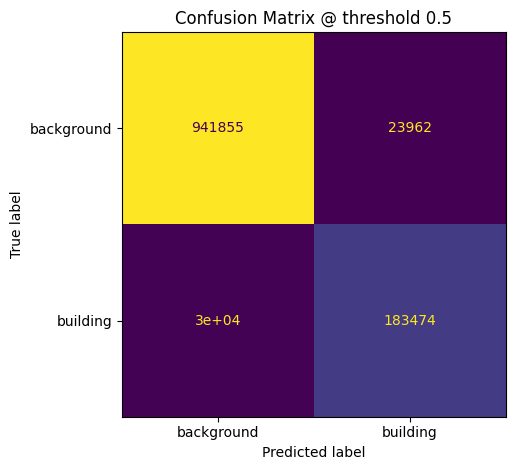

In [ ]:
import csv, numpy as np

# === 讀入你先前程式已算好的資料 ===
metrics_csv = "metrics.csv"
val_pred_npz = "val_pred.npz"

# ── 1. Dice-by-epoch  ───────────────────────────────────────────────
epochs, dice = [], []
with open(metrics_csv, newline="") as f:
    for row in csv.DictReader(f):
        epochs.append(int(row["epoch"]))
        dice.append(float(row["dice"]))

with open("dice_by_epoch.csv", "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["epoch", "dice"])
    w.writerows(zip(epochs, dice))
print("✅ dice_by_epoch.csv  已寫出")
plt.figure()
plt.plot(epochs, dice, marker='o')
plt.xlabel("epoch"); plt.ylabel("dice coefficient")
plt.title("Dice Coefficient by Epoch")
plt.grid(); plt.tight_layout()
plt.savefig("dice_curve.png")

# ── 2. Precision-Recall 曲線  ───────────────────────────────────────
dat = np.load(val_pred_npz)
y_true, y_score = dat["y_true"], dat["y_score"]

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true, y_score)

# precision, recall 長度 = len(thresholds)+1，為了對齊，先手動補最後一個門檻值 1.0
thresholds = np.append(thresholds, 1.0)

with open("pr_curve.csv", "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["threshold", "recall", "precision"])
    w.writerows(zip(thresholds, recall, precision))
print("✅ pr_curve.csv       已寫出")
plt.figure()
plt.plot(recall, precision, marker='o')
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(); plt.tight_layout()
plt.savefig("pr_curve.png")
# === 3. Loss Curve ────────────────────────────────────────────────
import matplotlib.pyplot as plt

# 如果 metrics.csv 還有 train_loss / val_loss 欄，讀進來：
train_loss, val_loss = [], []
with open(metrics_csv, newline="") as f:
    for row in csv.DictReader(f):
        train_loss.append(float(row["train_loss"]))
        val_loss.append(float(row["val_loss"]))

plt.figure()
plt.plot(epochs, train_loss, label="train loss")
plt.plot(epochs, val_loss,  label="val loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss Curve")
plt.grid(); plt.legend()
plt.tight_layout()
plt.savefig("loss_curve.png")
print("✅ loss_curve.png     已寫出")

# === 4. Confusion Matrix ──────────────────────────────────────────
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 以固定門檻 0.5 取 y_pred；如要用最佳 F1 門檻可自行替換
y_pred = (y_score >= 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred, labels=[0,1])   # [[TN, FP], [FN, TP]]

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(cm, display_labels=["background", "building"])  # 按你的類別改
disp.plot(cmap=None, ax=ax, colorbar=False)  # 不指定 color 以符合預設
ax.set_title("Confusion Matrix @ threshold 0.5")
plt.tight_layout()
fig.savefig("conf_matrix.png")
print("✅ conf_matrix.png    已寫出")


In [ ]:
# ------------------ Demo Predict (RGB + Depth，滑窗版 1024×1024) ------------------
"""
此腳本示範如何對 **RGB 圖 + 單通道深度圖** 進行語意分割推論。
假設模型輸入為 4 通道（RGB→3 + Depth→1）。
"""
import os
from typing import Tuple, List

import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
import torchvision

# ------------------------------------------------------------
# ⚙️ 1. 手動設定
# ------------------------------------------------------------
RGB_PATH   = r"E:\論文\空拍地圖語意分割\Depth4UNet\AerialImageDataset\test\images\bellingham1.tif"      # 三通道 RGB 影像
DEPTH_PATH = r"E:\論文\空拍地圖語意分割\Depth4UNet\depth\bellingham1_depth.png"    # 對應深度圖 (單通道 or 16‑bit)
CKPT_PATH  = r"E:\論文\空拍地圖語意分割\Depth4UNet\checkpoints\best_unet4ch(GELU_Inverted Bottleneck).pth"

WINDOW_SIZE = 1024  # 滑窗大小
STRIDE      = 512   # 滑窗步長（50% 重疊，減少邊界效應）

# ------------------------------------------------------------
# ⚙️ 2. 運算裝置
# ------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Using device:", DEVICE)

# ------------------------------------------------------------
# ⚙️ 3. 載入模型（UNet11_4ch，RGBD → 1 類）
# ------------------------------------------------------------
#from model import UNet11_4ch  # 若想換 UNet16_4ch，這裡替換即可

model = UNet11_4ch(pretrained=False).to(DEVICE).eval()
model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE))

# ------------------------------------------------------------
# ⚙️ 4. 影像讀取
# ------------------------------------------------------------
print("📥 Loading images …")
# 讀取 RGB（H×W×3，uint8）
rgb_img = Image.open(RGB_PATH).convert("RGB")
# 讀取 Depth（H×W 單通道）；自動轉成 8‑bit 再正規化 0–1
raw_depth = Image.open(DEPTH_PATH)
if raw_depth.mode != "L":  # 16‑bit or 32‑bit
    depth_np = np.array(raw_depth, dtype=np.float32)
    # 依整張圖做 min‑max → 0‑255 再轉 uint8（便於與 RGB 同步前處理）
    depth_np = 255.0 * (depth_np - depth_np.min()) / max(depth_np.ptp(), 1e-6)
    depth_img = Image.fromarray(depth_np.astype(np.uint8))
else:
    depth_img = raw_depth

W, H = rgb_img.size
print(f"📐 Image size: {W}×{H}")

# ------------------------------------------------------------
# ⚙️ 5. 前處理函式
# ------------------------------------------------------------
# 針對 RGB 的 torchvision 標準化 (ImageNet)
_rgb_tf = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
])

# Depth → Tensor (0–1) 直接線性拉伸；不做均值方差正規化（依照你訓練時的做法調整）
_depth_tf = torchvision.transforms.ToTensor()  # 會得到 0–1 float32


def preprocess_patch(rgb_patch: Image.Image, depth_patch: Image.Image) -> torch.Tensor:
    """將 RGB 與 Depth patch 轉為 (1,4,H,W) Tensor 並 pad 到 32 倍數"""
    t_rgb   = _rgb_tf(rgb_patch)
    t_depth = _depth_tf(depth_patch)  # shape (1,H,W)
    tensor  = torch.cat([t_rgb, t_depth], dim=0).unsqueeze(0).to(DEVICE)  # (1,4,H,W)
    return tensor


# ------------------------------------------------------------
# ⚙️ 6. Pad‑to‑32 工具
# ------------------------------------------------------------

def pad32(x: torch.Tensor) -> Tuple[torch.Tensor, int, int]:
    """Pad tensor (N,C,H,W) 到 32 的倍數，回傳 pad 後 tensor 與 pady、padx"""
    _, _, h, w = x.shape
    ph = (32 - h % 32) % 32
    pw = (32 - w % 32) % 32
    return F.pad(x, (0, pw, 0, ph)), ph, pw


# ------------------------------------------------------------
# ⚙️ 7. 小圖直接預測
# ------------------------------------------------------------

def direct_predict(rgb_np: np.ndarray, depth_np: np.ndarray) -> np.ndarray:
    print("📸 Image is small, using direct prediction…")
    rgb_pil   = Image.fromarray(rgb_np)
    depth_pil = Image.fromarray(depth_np)

    tensor_img = preprocess_patch(rgb_pil, depth_pil)
    tensor_pad, ph, pw = pad32(tensor_img)

    with torch.no_grad():
        logits = model(tensor_pad)
        if ph or pw:
            logits = logits[..., : logits.shape[-2] - ph, : logits.shape[-1] - pw]
        prob = torch.sigmoid(logits)[0, 0].cpu().numpy()
    return prob


# ------------------------------------------------------------
# ⚙️ 8. 滑窗預測
# ------------------------------------------------------------

def sliding_window_predict(rgb_np: np.ndarray, depth_np: np.ndarray,
                           window: int, stride: int) -> np.ndarray:
    H, W, _ = rgb_np.shape

    # 若圖片小於滑窗，直接預測
    if H <= window and W <= window:
        return direct_predict(rgb_np, depth_np)

    print("🖼️ Image is large, using sliding window prediction…")

    out_mask = np.zeros((H, W), dtype=np.float32)
    weight   = np.zeros((H, W), dtype=np.float32)

    y_pos = list(range(0, max(1, H - window + 1), stride))
    x_pos = list(range(0, max(1, W - window + 1), stride))

    if y_pos[-1] + window < H:
        y_pos.append(H - window)
    if x_pos[-1] + window < W:
        x_pos.append(W - window)

    total = len(y_pos) * len(x_pos)
    print(f"🔄 Processing {total} windows…")

    idx = 0
    for y in y_pos:
        for x in x_pos:
            idx += 1
            y_end, x_end = y + window, x + window
            rgb_win   = rgb_np[y: y_end, x: x_end]
            depth_win = depth_np[y: y_end, x: x_end]

            # 若邊界不足則 pad 至 window
            if rgb_win.shape[0] < window or rgb_win.shape[1] < window:
                pad_rgb   = np.zeros((window, window, 3), dtype=np.uint8)
                pad_depth = np.zeros((window, window), dtype=np.uint8)
                pad_rgb[: rgb_win.shape[0], : rgb_win.shape[1], :]   = rgb_win
                pad_depth[: depth_win.shape[0], : depth_win.shape[1]] = depth_win
                rgb_win, depth_win = pad_rgb, pad_depth

            tensor_pad, ph, pw = pad32(preprocess_patch(Image.fromarray(rgb_win),
                                                        Image.fromarray(depth_win)))
            with torch.no_grad():
                logits = model(tensor_pad)
                if ph or pw:
                    logits = logits[..., : logits.shape[-2] - ph, : logits.shape[-1] - pw]
                prob = torch.sigmoid(logits)[0, 0].cpu().numpy()

                # 若邊界 pad → 裁回原大小
                prob = prob[: rgb_win.shape[0], : rgb_win.shape[1]]

            out_mask[y: y_end, x: x_end] += prob[: y_end - y, : x_end - x]
            weight[y: y_end, x: x_end]   += 1.0

            if idx % 10 == 0 or idx == total:
                print(f"  Progress: {idx}/{total} ({idx / total * 100:.1f}%)")

    return np.divide(out_mask, weight, out=np.zeros_like(out_mask), where=weight != 0)


# ------------------------------------------------------------
# ⚙️ 9. 執行預測
# ------------------------------------------------------------
print("🔍 Starting prediction…")

rgb_np   = np.array(rgb_img)
depth_np = np.array(depth_img)

prob_mask = sliding_window_predict(rgb_np, depth_np, WINDOW_SIZE, STRIDE)

# ------------------------------------------------------------
# ⚙️ 10. 後處理與儲存
# ------------------------------------------------------------
THRESH = 0.5
binary = (prob_mask > THRESH).astype(np.uint8) * 255

mask_rgb = np.zeros((*binary.shape, 3), dtype=np.uint8)
mask_rgb[..., 1] = binary  # 綠色

blend = Image.blend(rgb_img, Image.fromarray(mask_rgb), alpha=0.4)

out_base = os.path.splitext(RGB_PATH)[0]
blend.save(out_base + "_RGBD_pred.png")
Image.fromarray(binary).save(out_base + "_RGBD_mask.png")

print("✅ Saved blended result:", out_base + "_RGBD_pred.png")
print("✅ Saved mask:", out_base + "_RGBD_mask.png")
print("🎉 Prediction completed!")


🚀 Using device: cuda


c:\Users\op237\miniconda3\envs\Depth4UNet\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\op237\miniconda3\envs\Depth4UNet\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\op237\AppData\Local\Temp\ipykernel_21292\2759003785.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default valu

📥 Loading images …
📐 Image size: 5000×5000
🔍 Starting prediction…
🖼️ Image is large, using sliding window prediction…
🔄 Processing 81 windows…
  Progress: 10/81 (12.3%)
  Progress: 20/81 (24.7%)
  Progress: 30/81 (37.0%)
  Progress: 40/81 (49.4%)
  Progress: 50/81 (61.7%)
  Progress: 60/81 (74.1%)
  Progress: 70/81 (86.4%)
  Progress: 80/81 (98.8%)
  Progress: 81/81 (100.0%)
✅ Saved blended result: E:\論文\空拍地圖語意分割\Depth4UNet\AerialImageDataset\test\images\bellingham1_RGBD_pred.png
✅ Saved mask: E:\論文\空拍地圖語意分割\Depth4UNet\AerialImageDataset\test\images\bellingham1_RGBD_mask.png
🎉 Prediction completed!
